Github Repository Link: https://github.com/DStull99/MSCS-Boulder-Machine-Learning-Final-Projects/tree/main

DESCRIPTION: For safe and secure lending experience, it's important to analyze the past data. In this project, we will build a deep learning model to predict the chance of default for future loans using the historical data. As we will see, this dataset is highly imbalanced and includes a lot of features that make this problem more challenging.

Objective: Create a model that predicts whether or not an applicant will be able to repay a loan using historical data.

Domain: Finance

Analysis to be done: Perform data preprocessing and build a deep learning prediction model.

Steps to be done:

⦁ Load the dataset 
⦁ Check for null values in the dataset
⦁ Print percentage of default to payer of the dataset for the TARGET column
⦁ Balance the dataset if the data is imbalanced
⦁ Plot the balanced data or imbalanced data
⦁ Encode the columns that is required for the model
⦁ Calculate Sensitivity as a metric
⦁ Calculate area under receiver operating characteristics curve

In [26]:
# Importing the Relevant Libraries: 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt 

In [12]:
# Defining a function to load the data, with an option to load a specified number of samples:

def load_data(path, sample_n=None, random_state=42):
    df = pd.read_csv(path)
    if sample_n:
        df = df.sample(n=sample_n, random_state=random_state)
    return df

In [13]:
# Defining a function to clean the data. We will drop any features with >= 40% of its values missing,
# and imputing the median value for the rest:

def clean_data(df, missing_thresh=0.4):
    missing_pct = df.isnull().mean()
    cols_to_drop = missing_pct[missing_pct > missing_thresh].index
    df = df.drop(columns=cols_to_drop)
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in [np.float64, np.int64]:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].value_counts().idxmax(), inplace=True)
    return df

In [14]:
# Defining a function to handle class imbalance. We will allow both oversampling and undersampling methods to 
# test the differences in results:

def balance_data(df, target='TARGET', method='oversample'):
    df_major = df[df[target] == 0]
    df_minor = df[df[target] == 1]
    if method == 'undersample':
        df_major = df_major.sample(n=len(df_minor), random_state=42)
        df_bal = pd.concat([df_major, df_minor], ignore_index=True)
    elif method == 'oversample':
        df_minor_over = df_minor.sample(n=len(df_major), replace=True, random_state=42)
        df_bal = pd.concat([df_major, df_minor_over], ignore_index=True)
    else:
        df_bal = df  
    return df_bal.sample(frac=1, random_state=42)

In [15]:
# Defining a function to encode categorical columns:

def encode_features(df):
    if 'SK_ID_CURR' in df.columns:
        df = df.drop('SK_ID_CURR', axis=1)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df

In [16]:
# Defining a function to split the data into train and test sets:
def split_and_scale(df, target='TARGET'):
    X = df.drop(target, axis=1)
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    num_cols = X_train.select_dtypes(include=['int64','float64']).columns
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    return X_train, X_test, y_train, y_test

In [21]:
# Defining a function to build and train the model:

def build_and_train_model(X_train, y_train, class_weights=None):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Recall(name='sensitivity'), keras.metrics.AUC(name='auc'), 
                           keras.metrics.Precision(name='precision')])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
              class_weight=class_weights, verbose=1)
    return model

In [24]:
# Executing the defined functions and obtaining the results:
df = load_data('loan_data (1).csv')
print(f"Data shape before cleaning: {df.shape}")
df.info()
df = clean_data(df, missing_thresh=0.40)
print(f"Data shape after cleaning: {df.shape}")
print(f'Imbalanced class counts: {df.TARGET.value_counts().to_dict()}')
df = balance_data(df, target='TARGET', method='oversample')
print(f"Balanced class counts: {df.TARGET.value_counts().to_dict()}")
df = encode_features(df)
print(df.shape)
X_train, X_test, y_train, y_test = split_and_scale(df, target='TARGET')
model = build_and_train_model(X_train, y_train)
loss, sensitivity, auc, precision = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Test Sensitivity: {sensitivity:.3f}")
print(f"Model Test AUC-ROC: {auc:.3f}")
print(f"Model Test Precision: {precision:.3f}")


Data shape before cleaning: (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
Data shape after cleaning: (307511, 73)
Imbalanced class counts: {0: 282686, 1: 24825}
Balanced class counts: {0: 282686, 1: 282686}
(565372, 172)
Epoch 1/20
11308/11308 [==============================] - 14s 1ms/step - loss: 0.5939 - sensitivity: 0.6931 - auc: 0.7474 - precision: 0.6798 - val_loss: 0.5835 - val_sensitivity: 0.7250 - val_auc: 0.7591 - val_precision: 0.6789
Epoch 2/20
11308/11308 [==============================] - 20s 2ms/step - loss: 0.5710 - sensitivity: 0.7269 - auc: 0.7706 - precision: 0.6904 - val_loss: 0.5655 - val_sensitivity: 0.7210 - val_auc: 0.7756 - val_precision: 0.6979
Epoch 3/20
11308/11308 [==============================] - 18s 2ms/step - loss: 0.5517 - sensitivity: 0.7507 - auc: 0.7877 - precision: 0.6990 - v

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model):
        self.keras_model = keras_model
        self.classes_ = np.array([0, 1])  # Explicitly define classes_ to match sklearn format

    def fit(self, X, y):
        pass  # No need to retrain the model

    def predict(self, X):
        return (self.keras_model.predict(X) > 0.5).astype(int)  # Convert probabilities to class labels

    def predict_proba(self, X):
        probs = self.keras_model.predict(X)
        return np.hstack([1 - probs, probs])  # Convert to [P(class=0), P(class=1)] format



3534/3534 [==============================] - 2s 606us/step


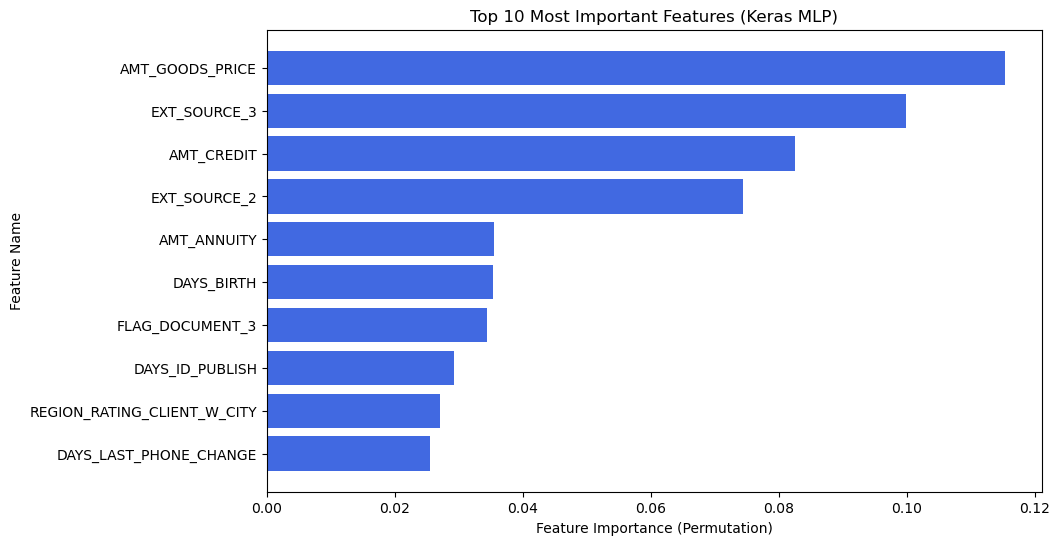

In [31]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Wrap the trained Keras model
wrapped_model = KerasWrapper(model)

# Compute permutation importance
perm_importance = permutation_importance(wrapped_model, X_test, y_test, scoring="roc_auc", n_repeats=5, random_state=42)

# Extract feature names and importance scores
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"][:10], feature_importance["Importance"][:10], color="royalblue")
plt.xlabel("Feature Importance (Permutation)")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features (Keras MLP)")
plt.gca().invert_yaxis()  # Show most important feature at the top
plt.show()
